In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from d2l import torch as d2l

/opt/homebrew/Caskroom/miniforge/base/envs/d2l/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/d2l/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <FB2FD416-6C4D-3621-B677-61F07C02A3C5> /opt/homebrew/Caskroom/miniforge/base/envs/d2l/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/d2l/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/d2l/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/d2l/lib/python3.9/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/d2l/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `

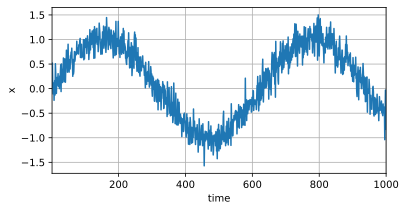

In [2]:
T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

## 马尔可夫

In [5]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [6]:
features

tensor([[ 0.0318,  0.5195,  0.0974, -0.1071],
        [ 0.5195,  0.0974, -0.1071,  0.1136],
        [ 0.0974, -0.1071,  0.1136,  0.1167],
        ...,
        [-0.3754, -0.4463, -1.0387, -0.5507],
        [-0.4463, -1.0387, -0.5507, -0.0309],
        [-1.0387, -0.5507, -0.0309, -0.3657]])

In [7]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(), nn.Linear(10, 1))
    net.apply(init_weights)
    return net

loss = nn.MSELoss()

In [10]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')
        
net = get_net()
train(net, train_iter, loss, 10, 0.01)

epoch 1, loss: 0.050125
epoch 2, loss: 0.045729
epoch 3, loss: 0.046503
epoch 4, loss: 0.045007
epoch 5, loss: 0.045121
epoch 6, loss: 0.044076
epoch 7, loss: 0.044871
epoch 8, loss: 0.044573
epoch 9, loss: 0.043921
epoch 10, loss: 0.043499


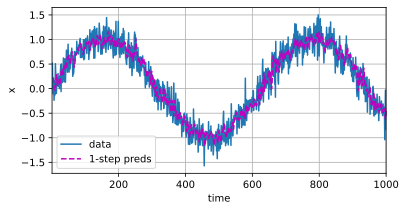

In [11]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]], [x.detach().numpy(), onestep_preds.detach().numpy()],
         'time', 'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

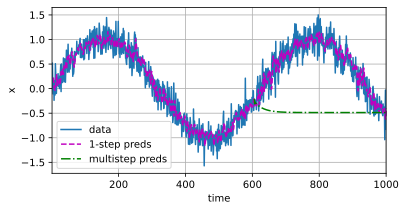

In [12]:
multi_step_preds = torch.zeros(T)
multi_step_preds[:n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
    multi_step_preds[i] = net(multi_step_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multi_step_preds[n_train + tau:].detach().numpy()], 'time', 'x',
         legend=['data', '1-step preds', 'multistep preds'], xlim=[1, 1000],
         figsize=(6, 3))

## 浅变量